# Storage Story: Exploratory Analysis of Personal Media Storage Metadata
**Personal Media Storage Metadata**

**Framework:** Google Data Analytics Capstone (Ask, Prepare, Process, Analyze, Share, Act)

**Author:** Hans Darmawan  
**Language:** Python  
**Analysis Type:** Exploratory Data Analysis (EDA)

---

## Project Context

This case study applies exploratory data analysis (EDA) to **anonymized personal media storage metadata** generated from photography and videography activities. As media files accumulate over time, storage usage increases rapidly, making it increasingly difficult to plan storage capacity and manage archives efficiently.

Using the **Google Data Analytics Capstone framework**, this analysis focuses on understanding **how storage is consumed**, **which file types contribute most to storage growth**, and **how shooting behavior changes over time**. The objective is to transform raw file-level metadata into clear, actionable insights that support better storage planning and long-term archive management.


## Business Task Summary

The purpose of this analysis is to explore and understand the dataset in order to identify meaningful patterns, data quality issues, and insights that can support informed decision-making. This project follows the Google Data Analytics Capstone framework and focuses on insight generation rather than predictive modeling.

## 0. Setup & Environment

This section initializes the Python environment and libraries used throughout the analysis.

In [28]:
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Pandas display configuration
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

# Visualization style
sns.set_theme(style="whitegrid")

# Project paths
BASE_DIR = Path("..")
DATASETS_DIR = BASE_DIR / "datasets"
FIGURES_DIR = BASE_DIR / "figures"

DATASETS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Dataset files
FILES_CLEAN_ENGINEERED_CSV = DATASETS_DIR / "files_clean_engineered.csv"

## 1. Ask

This phase defines the analytical objective by clarifying the business question, identifying key stakeholders, and establishing success criteria that guide the entire analysis.

The focus of this phase is to:
- Define the primary business question and analytical scope.  
- Identify stakeholders and their informational needs.  
- Establish success criteria for evaluating analytical outcomes.  
- Ensure alignment between business objectives and analytical approach.  

### 1.1. Business Question
How is personal media storage consumed over time, what patterns and trends exist across file categories, formats, and time periods, and what data quality considerations must be addressed to ensure reliable analysis and informed storage planning decisions?

### 1.2. Stakeholders
- **Data analysts and data scientists** – to understand data structure, limitations, and analytical opportunities  
- **Business or operational decision-makers** – to support storage capacity planning and archival strategies  
- **Project reviewers and external audiences** – to evaluate analytical rigor, clarity, and reproducibility  

### 1.3. Success Criteria
- A comprehensive understanding of dataset structure, completeness, and limitations  
- Clear, evidence-based insights into storage usage patterns and trends  
- A transparent, reproducible analysis that can be extended for deeper or future investigations  

## 2. Prepare

This phase focuses on understanding the data source, structure, and overall reliability of the dataset. The objective is to assess whether the data is suitable for analysis, identify potential quality issues, and establish context before any transformation or exploration is performed.

The focus of this phase is to:
- Review the dataset structure, data types, and record volume.  
- Assess data completeness and identify potential quality concerns.  
- Understand key fields relevant to storage usage and aggregation.  
- Establish initial assumptions and constraints for subsequent analysis.  

### 2.1. Dataset Overview and Initial Assessment

The dataset represents anonymized file-level metadata extracted from a personal media storage system and is derived from a **Digikam database**. All identifiers and sensitive attributes have been **masked and adjusted** to preserve privacy while retaining analytical integrity. The dataset contains **108,598 records** and **8 columns**, where each row corresponds to a single media file.

The dataset is structured to support analysis of storage usage, file characteristics, and temporal patterns, without exposing personal or sensitive information.

#### 2.1.1. Dataset Fields Description
- **`albumRootId`**  
  Identifier representing the top-level album grouping, enabling aggregation at a broader collection level.

- **`albumId`**  
  Identifier for individual albums within an album root, supporting hierarchical album analysis.

- **`imageId`**  
  Unique identifier for each media file, allowing file-level granularity and traceability.

- **`fileCategory`**  
  Numeric code representing the media category, intended for categorical grouping and efficient storage classification.

- **`fileCategoryName`**  
  Human-readable label for the media category, used for interpretation and reporting purposes.

- **`fileSize`**  
  File size stored in bytes, providing precise measurement for storage consumption analysis and aggregation.

- **`fileDate`**  
  File creation date recorded as a string, representing the temporal dimension of media generation and requiring conversion for time-based analysis.

- **`format`**  
  File format or extension, used to analyze format diversity and its impact on storage usage.

In [29]:
DATA_PATH = "../datasets/files.csv"

df = pd.read_csv(DATA_PATH, sep=";")

df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108598 entries, 0 to 108597
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   albumRootId       108598 non-null  int64 
 1   albumId           108598 non-null  int64 
 2   imageId           108598 non-null  int64 
 3   fileCategory      108598 non-null  int64 
 4   fileCategoryName  108598 non-null  object
 5   fileSize          108598 non-null  int64 
 6   fileDate          108598 non-null  object
 7   format            108598 non-null  object
dtypes: int64(5), object(3)
memory usage: 6.6+ MB


,albumRootId,albumId,imageId,fileCategory,fileCategoryName,fileSize,fileDate,format
0,2,6,25,1,Image,48218,2011-01-19,JPG
1,2,7,37,1,Image,50298,2015-11-20,JPG
2,2,8,50,1,Image,55420,2021-11-19,JPG
3,2,10,60,1,Image,20967,2018-11-02,JPG
4,2,11,70,1,Image,53573,2024-10-25,JPG


#### 2.1.2. Structural Observations
- All columns have **100% non-null values**, indicating a complete dataset with no missing entries.
- The dataset occupies approximately **6.6 MB of memory**, making it efficient for in-memory exploratory analysis.
- Data types are split between numeric identifiers (`int64`) and descriptive attributes (`object`).

#### 2.1.3. Column Characteristics
- **Numeric Identifiers (`int64`)**
  - `albumRootId`, `albumId`, and `imageId` enable hierarchical grouping at different album and file levels.
  - `fileCategory` represents a numeric classification of media type.
  - `fileSize` stores file size in raw bytes, allowing precise aggregation and flexible unit conversion.

- **Categorical Attributes (`object`)**
  - `fileCategoryName` provides a human-readable media category label.
  - `format` represents the file extension or media format.

- **Temporal Attribute (`object`)**
  - `fileDate` is stored as a string and requires conversion to a datetime format before time-based analysis.

#### 2.1.4. Analytical Implications
- The absence of missing values minimizes preprocessing complexity and reduces the risk of bias introduced through imputation.
- Converting `fileDate` to a datetime format is required before performing temporal analysis.
- Storing file sizes in bytes supports accurate storage aggregation and unit conversion.


### 2.2. Data Quality Overview

This section evaluates column-level completeness and data types to assess the overall quality and reliability of the dataset prior to processing and analysis.

In [30]:
summary_df = pd.DataFrame(
    {
        "column": df.columns,
        "data_type": df.dtypes.astype(str),
        "non_null_count": df.notna().sum(),
        "missing_percentage": (df.isna().mean() * 100).round(2),
    }
)

summary_df

,column,data_type,non_null_count,missing_percentage
albumRootId,albumRootId,int64,108598,0.0
albumId,albumId,int64,108598,0.0
imageId,imageId,int64,108598,0.0
fileCategory,fileCategory,int64,108598,0.0
fileCategoryName,fileCategoryName,object,108598,0.0
fileSize,fileSize,int64,108598,0.0
fileDate,fileDate,object,108598,0.0
format,format,object,108598,0.0


The table above summarizes column-level completeness and data types across the dataset.

#### 2.2.1. Completeness Assessment
- All columns show **100% non-null values**, with a missing percentage of **0.0%** across the dataset.
- No imputation or row-level filtering is required based on missing data.
- The absence of missing values reduces the risk of analytical bias introduced during preprocessing.

#### 2.2.2. Data Type Assessment
- Numeric fields (`int64`) are consistently used for identifiers and file size values, supporting efficient aggregation and filtering.
- Descriptive attributes such as `fileCategoryName` and `format` are stored as categorical text (`object`).
- The `fileDate` column is stored as a string (`object`) and requires conversion to a datetime type for temporal analysis.

#### 2.2.3. Analytical Implications
- The dataset is structurally complete and suitable for exploratory and aggregate analysis without additional data repair.
- Explicit type conversion for `fileDate` is necessary to enable trend analysis, seasonality assessment, and time-based grouping.
- With no missing values present, subsequent analysis can focus on pattern discovery rather than data recovery.

## 3. Process

This phase documents the steps taken to clean and prepare the dataset for analysis. All processing decisions are intentionally minimal and transparent, with the objective of preserving the original data structure while enabling reliable exploratory analysis.

The focus of this phase is to:
- Verify data integrity through missing value and duplication checks.  
- Prepare fields for aggregation and temporal analysis.  
- Ensure transformations are additive and reproducible rather than destructive.  

### 3.1. Missing Value Assessment

A column-wise missing value check was conducted to assess data completeness and determine whether any preprocessing steps were required to address null entries prior to analysis.

In [31]:
missing_counts = df.isnull().sum()

missing_counts

albumRootId         0
albumId             0
imageId             0
fileCategory        0
fileCategoryName    0
fileSize            0
fileDate            0
format              0
dtype: int64

#### 3.1.1. Results
- All columns contain **zero missing values**.
- No null entries were detected across the dataset.

#### 3.1.2. Processing Implications
- No imputation or record-level filtering is required prior to analysis.
- The dataset can be analyzed in full without introducing bias related to missing-value handling.

### 3.2. Duplicate Record Assessment

A duplicate record check was conducted to identify fully repeated rows that could distort aggregate metrics and distribution-based analysis.

In [32]:
duplicated_counts = df.duplicated().sum()

duplicated_counts

np.int64(0)

#### 3.2.1. Results
- No duplicate records were detected in the dataset.
- Each row represents a unique file-level observation.

#### 3.2.2. Processing Implications
- No deduplication steps are required prior to analysis.
- Aggregate counts and storage size calculations can be performed without risk of double-counting.

### 3.3. Working Dataset Creation

A separate working copy of the dataset was created to ensure that all cleaning and transformation steps could be applied without modifying the original raw data.

In [33]:
# Create a working copy to preserve the raw dataset
df_clean = df.copy()

#### 3.3.1. Rationale
- Maintaining an untouched raw dataset supports analytical transparency and reproducibility.
- A working copy allows iterative processing while preserving a reliable point of reference.

#### 3.3.2. Processing Implications
- All subsequent transformations and feature engineering steps are performed on the working dataset.
- The original dataset remains available for validation, comparison, or reprocessing if required.

### 3.4. Temporal Feature Engineering

The file creation date was converted from a string representation into a datetime format, and additional temporal attributes were derived to support time-based aggregation and trend analysis.

In [34]:
# parse yyyy-mm-dd into datetime
df_clean["fileDate"] = pd.to_datetime(
    df_clean["fileDate"],
    format="%Y-%m-%d",
    errors="coerce"
)

# derive date components
df_clean["year"] = df_clean["fileDate"].dt.year
df_clean["month"] = df_clean["fileDate"].dt.month
df_clean["month_name"] = df_clean["fileDate"].dt.month_name()
df_clean["day_of_week"] = df_clean["fileDate"].dt.day_name()
df_clean["day"] = df_clean["fileDate"].dt.day

df_clean.head()


,albumRootId,albumId,imageId,fileCategory,fileCategoryName,fileSize,fileDate,format,year,month,month_name,day_of_week,day
0,2,6,25,1,Image,48218,2011-01-19,JPG,2011,1,January,Wednesday,19
1,2,7,37,1,Image,50298,2015-11-20,JPG,2015,11,November,Friday,20
2,2,8,50,1,Image,55420,2021-11-19,JPG,2021,11,November,Friday,19
3,2,10,60,1,Image,20967,2018-11-02,JPG,2018,11,November,Friday,2
4,2,11,70,1,Image,53573,2024-10-25,JPG,2024,10,October,Friday,25


#### 3.4.1. Derived Temporal Attributes
- **`year`** enables long-term trend and year-over-year growth analysis.
- **`month`** and **`month_name`** support monthly distribution and seasonality analysis.
- **`day_of_week`** allows examination of weekly usage patterns.
- **`day`** provides finer-grained insight into within-month activity.

#### 3.4.2. Analytical Implications
- Converting `fileDate` to a datetime format standardizes temporal data and enables reliable time-based operations.
- Derived temporal fields reduce repetitive computation during analysis and improve clarity in downstream visualizations.
- This feature engineering step prepares the dataset for temporal trend analysis without altering the original date information.


### 3.5. File Size Normalization

File size values were converted from raw bytes into megabytes (MB) and gigabytes (GB) to improve interpretability and support storage-focused analysis at different scales.

In [35]:
# convert file size from bytes
df_clean["file_size_mb"] = df_clean["fileSize"] / (1024 ** 2)
df_clean["file_size_gb"] = df_clean["fileSize"] / (1024 ** 3)

# round values
df_clean["file_size_mb"] = df_clean["file_size_mb"].round(2)
df_clean["file_size_gb"] = df_clean["file_size_gb"].round(4)

df_clean.head()

,albumRootId,albumId,imageId,fileCategory,fileCategoryName,fileSize,fileDate,format,year,month,month_name,day_of_week,day,file_size_mb,file_size_gb
0,2,6,25,1,Image,48218,2011-01-19,JPG,2011,1,January,Wednesday,19,0.05,0.0000
1,2,7,37,1,Image,50298,2015-11-20,JPG,2015,11,November,Friday,20,0.05,0.0000
2,2,8,50,1,Image,55420,2021-11-19,JPG,2021,11,November,Friday,19,0.05,0.0001
3,2,10,60,1,Image,20967,2018-11-02,JPG,2018,11,November,Friday,2,0.02,0.0000
4,2,11,70,1,Image,53573,2024-10-25,JPG,2024,10,October,Friday,25,0.05,0.0000


#### 3.5.1. Normalized Size Metrics
- **`file_size_mb`** provides a human-readable unit suitable for analyzing typical image and small media files.
- **`file_size_gb`** enables clearer interpretation of large files and aggregate storage consumption.
- Rounding was applied to standardize presentation while preserving analytical usefulness.

#### 3.5.2. Analytical Implications
- Normalized size units improve clarity in descriptive statistics and visualizations.
- Using both MB and GB scales allows flexible analysis across small, medium, and very large files.
- This normalization facilitates comparison of storage impact across categories, formats, and time periods without altering the underlying file size information.


### 3.6. Defining Exploratory Data Analysis (EDA) Functions

This section defines the exploratory data analysis (EDA) functions used to examine media storage usage across categories, storage size, and temporal dimensions. The focus is on establishing reusable, consistent visualization and aggregation functions that enable systematic exploration in subsequent analysis stages.

#### 3.6.1. Category Distribution by File Count Visualization Function
This function is designed to support exploratory data analysis by visualizing the distribution of media files across categories based on file count.

In [36]:
def plot_category_count_pie(df):
    agg_df = (
        df.groupby("fileCategoryName")
        .size()
        .reset_index(name="file_count")
        .sort_values("file_count", ascending=False)
    )

    plt.figure(figsize=(7, 7))

    plt.pie(
        agg_df["file_count"],
        labels=agg_df["fileCategoryName"],
        autopct="%1.1f%%",
        startangle=90,
        counterclock=False,
        wedgeprops={"edgecolor": "white"},
        textprops={"fontsize": 12},
    )

    plt.title("File Count Distribution by Category", fontsize=14)
    plt.tight_layout()
    plt.show()

The function first aggregates the dataset by `fileCategoryName` and computes the total number of files per category. The aggregated results are then sorted in descending order to highlight dominant categories by volume.

A pie chart is used to represent the proportional contribution of each category to the total file count. Visual parameters such as start angle, label formatting, and edge styling are applied to improve readability and ensure consistent presentation. The resulting visualization provides a high-level overview of file volume distribution across media categories.

#### 3.6.2. Category Distribution by Storage Size Visualization Function
This function supports exploratory data analysis by visualizing how total storage consumption is distributed across media categories.

In [37]:
def plot_category_size_pie(df):
    agg_df = (
        df.groupby("fileCategoryName", as_index=False)["fileSize"]
        .sum()
        .assign(total_gb=lambda x: x["fileSize"] / (1024 ** 3))
        .sort_values("total_gb", ascending=False)
    )

    plt.figure(figsize=(7, 7))

    plt.pie(
        agg_df["total_gb"],
        labels=agg_df["fileCategoryName"],
        autopct="%1.1f%%",
        startangle=90,
        counterclock=False,
        wedgeprops={"edgecolor": "white"},
        textprops={"fontsize": 12},
    )

    plt.title("Storage Distribution by Category", fontsize=14)
    plt.tight_layout()
    plt.show()

The function aggregates the dataset by `fileCategoryName` and computes the total file size per category by summing raw byte values. The aggregated sizes are then converted into gigabytes to improve interpretability and enable proportional comparison across categories.

The resulting values are sorted in descending order to emphasize categories with the largest storage impact. A pie chart is used to display the proportional contribution of each category to total storage usage, with formatting applied to ensure readability and consistent presentation.


#### 3.6.3. Top-N Categorical Frequency Visualization Function
This function supports exploratory data analysis by visualizing the frequency distribution of a selected categorical variable, limited to the top *N* most frequent values.

In [38]:
def plot_count(
    df: pd.DataFrame,
    column: str,
    top_n: int = 10,
    title: Optional[str] = None,
) -> None:
    """
    Plot the frequency distribution of a categorical column and save the figure.
    """
    FIGURES_DIR.mkdir(parents=True, exist_ok=True)

    plt.figure(figsize=(12, 7))

    temp_df = df.copy()
    temp_df[column] = temp_df[column].astype(str)

    total_count = len(temp_df)
    counts = temp_df[column].value_counts().head(top_n)
    order = counts.index

    max_val = counts.max()
    min_val = counts.min()

    description = (
        f"Frequency Distribution of "
        f"{column.replace('_', ' ').title()} (Top {top_n})"
    )

    ax = sns.countplot(
        data=temp_df[temp_df[column].isin(order)],
        y=column,
        order=order,
        hue=column,
        palette="viridis",
        legend=False,
    )

    for patch in ax.patches:
        width = patch.get_width()
        percentage = 100 * width / total_count
        label = f"{int(width):,} ({percentage:.1f}%)"

        if width == max_val:
            text_color = "green"
            font_weight = "bold"
        elif width == min_val:
            text_color = "red"
            font_weight = "bold"
        else:
            text_color = "black"
            font_weight = "normal"

        ax.annotate(
            label,
            (width, patch.get_y() + patch.get_height() / 2),
            ha="left",
            va="center",
            xytext=(5, 0),
            textcoords="offset points",
            color=text_color,
            fontweight=font_weight,
        )

    ax.set_title(title or description, fontsize=14, pad=20)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])

    sns.despine(left=True, bottom=True)

    filename = description.replace(" ", "_").lower() + ".png"
    plt.savefig(FIGURES_DIR / filename, bbox_inches="tight", dpi=300)
    plt.show()

The function begins by creating a working copy of the dataset and standardizing the target column as a string to ensure consistent categorical handling. It then computes value counts for the specified column, selects the top *N* categories by frequency, and determines their relative ordering.

A horizontal bar chart is generated to display the frequency of each category. Each bar is annotated with both the absolute count and its percentage contribution relative to the full dataset. Visual emphasis is applied to the most and least frequent categories to improve interpretability.

The visualization is saved to disk for reuse and reproducibility, allowing the same function to be applied across different categorical dimensions during exploratory analysis.


#### 3.6.4. Top-N Categorical Storage Contribution Visualization Function

This function supports exploratory data analysis by visualizing the total aggregated storage contribution of a selected categorical variable, limited to the top *N* categories by size.

In [39]:
def plot_sum(
    df: pd.DataFrame,
    column: str,
    value_col: str = "file_size_mb",
    top_n: int = 10,
    title: Optional[str] = None,
) -> None:
    """
    Plot the total aggregated value of a column and save the figure.
    """
    FIGURES_DIR.mkdir(parents=True, exist_ok=True)

    plt.figure(figsize=(14, 7))

    sum_df = (
        df.groupby(column, as_index=False)[value_col]
        .sum()
        .sort_values(value_col, ascending=False)
        .head(top_n)
    )

    sum_df[column] = sum_df[column].astype(str)

    total_value = sum_df[value_col].sum()
    max_val = sum_df[value_col].max()
    min_val = sum_df[value_col].min()

    description = (
        f"Total {value_col.replace('_', ' ').title()} of "
        f"{column.replace('_', ' ').title()} (Top {top_n})"
    )

    ax = sns.barplot(
        data=sum_df,
        x=value_col,
        y=column,
        hue=column,
        palette="magma",
        legend=False,
    )

    # ------------------------------------------------------------------
    # Annotate bars (value + percentage)
    # ------------------------------------------------------------------
    for patch in ax.patches:
        width = patch.get_width()
        percentage = 100 * width / total_value

        if width >= 1024:
            value_label = f"{width / 1024:.2f} GB"
        else:
            value_label = f"{width:.1f} MB"

        label = f"{value_label} ({percentage:.1f}%)"

        if width == max_val:
            text_color = "green"
            font_weight = "bold"
        elif width == min_val:
            text_color = "red"
            font_weight = "bold"
        else:
            text_color = "black"
            font_weight = "normal"

        ax.annotate(
            label,
            (width, patch.get_y() + patch.get_height() / 2),
            ha="left",
            va="center",
            xytext=(6, 0),
            textcoords="offset points",
            color=text_color,
            fontweight=font_weight,
        )

    ax.set_title(title or description, fontsize=14, pad=20)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])

    sns.despine(left=True, bottom=True)

    filename = description.replace(" ", "_").lower() + ".png"
    plt.savefig(FIGURES_DIR / filename, bbox_inches="tight", dpi=300)
    plt.show()


The function groups the dataset by the specified categorical column and computes the total storage usage by summing the selected size metric. The aggregated results are sorted in descending order, and only the top *N* categories with the largest storage contribution are retained for visualization.

A horizontal bar chart is used to display the relative storage impact of each category. Each bar is annotated with both the absolute storage value and its percentage contribution to the total aggregated size. Conditional formatting is applied to highlight the categories with the highest and lowest storage impact among the selected group.

The resulting visualization is saved for reproducibility and enables consistent comparison of storage-heavy categories across different dimensions during exploratory analysis.

#### 3.6.5. Dynamic Top-N Selection Utility Function
This helper function determines a safe upper bound for the *Top-N* parameter used in categorical visualizations by comparing the requested maximum value with the number of unique categories present in the dataset.

In [40]:
def get_top_n(df: pd.DataFrame, column: str, max_top_n: int = 10) -> int:
    """Return a safe top_n value based on unique category count."""
    return min(max_top_n, df[column].nunique())

By returning the smaller of the two values, the function ensures that visualization logic remains robust and does not attempt to plot more categories than actually exist. This utility supports consistent and reusable exploratory analysis across categorical dimensions with varying cardinality.

#### 3.6.6. Temporal File Count Trend Visualization Function
This function supports exploratory data analysis by visualizing the trend of file counts over time along a specified temporal dimension, such as year.

In [41]:
def plot_trend_count(
    df: pd.DataFrame,
    column: str = "year",
    title: Optional[str] = None,
) -> None:
    """
    Plot the trend of record counts over time with percentage progression
    and save the figure.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    column : str, default="year"
        Column representing the time axis.
    title : str, optional
        Custom plot title.
    """
    FIGURES_DIR.mkdir(parents=True, exist_ok=True)

    trend_df = (
        df.groupby(column)
        .size()
        .reset_index(name="file_count")
        .sort_values(column)
    )

    trend_df["progression"] = trend_df["file_count"].pct_change() * 100

    description = (
        f"Frequency Distribution of "
        f"{column.replace('_', ' ').title()} over Time"
    )

    plt.figure(figsize=(14, 8))

    ax = sns.lineplot(
        data=trend_df,
        x=column,
        y="file_count",
        marker="o",
        linewidth=2,
    )

    for _, row in trend_df.iterrows():
        x = row[column]
        y = row["file_count"]
        progression = row["progression"]

        ax.annotate(
            f"{int(y):,}",
            xy=(x, y),
            xytext=(0, 12),
            textcoords="offset points",
            ha="center",
            fontweight="bold",
        )

        if not pd.isna(progression):
            color = "green" if progression >= 0 else "red"
            sign = "+" if progression > 0 else ""

            ax.annotate(
                f"{sign}{progression:.1f}%",
                xy=(x, y),
                xytext=(0, -18),
                textcoords="offset points",
                ha="center",
                va="top",
                color=color,
                fontweight="bold",
            )

    ax.set_title(title or description, fontsize=14, pad=30)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks(trend_df[column].unique())

    sns.despine()

    filename = description.replace(" ", "_").lower() + ".png"
    output_path = FIGURES_DIR / filename

    plt.savefig(output_path, bbox_inches="tight", dpi=300)
    plt.show()

The function groups the dataset by the selected time column and computes the total number of files for each time period. The resulting series is ordered chronologically to preserve temporal continuity. A percentage progression metric is calculated to capture relative changes in file count between consecutive periods.

A line chart is used to display the evolution of file counts over time. Each data point is annotated with the absolute file count, while the corresponding percentage change from the previous period is displayed to highlight growth or decline. Visual cues are applied to distinguish positive and negative progression.

The resulting visualization is saved for reproducibility and provides a structured view of temporal growth patterns in file creation activity.

#### 3.6.7. Temporal Storage Size Trend Visualization Function
This function supports exploratory data analysis by visualizing how total storage consumption evolves over time along a specified temporal dimension, such as year.

In [42]:
def plot_trend_sum(
    df: pd.DataFrame,
    column: str = "year",
    value_col: str = "fileSize",
    title: Optional[str] = None,
) -> None:
    """
    Plot the trend of total file size over time with percentage progression
    and save the figure.
    """
    assert column in df.columns, f"Column '{column}' not found in DataFrame"
    assert value_col in df.columns, f"Column '{value_col}' not found in DataFrame"

    FIGURES_DIR.mkdir(parents=True, exist_ok=True)

    trend_df = (
        df.groupby(column, as_index=False)[value_col]
        .sum()
        .assign(total_gb=lambda x: x[value_col] / (1024 ** 3))
        .sort_values(column)
    )

    trend_df["progression"] = trend_df["total_gb"].pct_change() * 100

    description = (
        f"Total File Size of "
        f"{column.replace('_', ' ').title()} over Time"
    )

    plt.figure(figsize=(14, 8))

    ax = sns.lineplot(
        data=trend_df,
        x=column,
        y="total_gb",
        marker="o",
        linewidth=2,
    )

    for _, row in trend_df.iterrows():
        x = row[column]
        y = row["total_gb"]
        progression = row["progression"]

        ax.annotate(
            f"{y:.2f} GB",
            xy=(x, y),
            xytext=(0, 12),
            textcoords="offset points",
            ha="center",
            fontweight="bold",
        )

        if not pd.isna(progression):
            color = "green" if progression >= 0 else "red"
            sign = "+" if progression > 0 else ""

            ax.annotate(
                f"{sign}{progression:.1f}%",
                xy=(x, y),
                xytext=(0, -18),
                textcoords="offset points",
                ha="center",
                va="top",
                color=color,
                fontweight="bold",
            )

    ax.set_title(title or description, fontsize=14, pad=30)
    ax.set_xlabel("")
    ax.set_ylabel("Total Size (GB)")
    ax.set_xticks(trend_df[column].unique())

    sns.despine()

    filename = description.replace(" ", "_").lower() + ".png"
    output_path = FIGURES_DIR / filename

    plt.savefig(output_path, bbox_inches="tight", dpi=300)
    plt.show()


The function groups the dataset by the selected time column and computes the total file size for each time period by summing raw size values. The aggregated sizes are converted into gigabytes to improve interpretability and enable comparison across periods. A percentage progression metric is calculated to capture relative changes in storage usage between consecutive time intervals.

A line chart is used to display the temporal trend of total storage consumption. Each data point is annotated with the absolute storage value, while the corresponding percentage change from the previous period highlights growth or decline dynamics. The visualization is saved to support reproducibility and consistent comparison across temporal analyses.

### 3.7. Exporting the Processed Dataset

After completing data cleaning and feature engineering steps, the processed dataset was exported to a structured CSV file. This export preserves the engineered features and standardized formats required for exploratory analysis and ensures that subsequent analysis can be reproduced or extended without repeating preprocessing steps.

The exported dataset serves as the analytical baseline for all exploratory data analysis and visualization performed in later stages.


In [43]:
df_clean.to_csv(
    FILES_CLEAN_ENGINEERED_CSV,
    sep=";",
    index=False,
)

## 4. Analyze

This phase explores patterns, distributions, and relationships within the dataset to generate insights related to media storage usage, file characteristics, and temporal behavior.

The focus of this phase is to:
- Examine distributions of files and storage consumption across categories and formats.  
- Identify dominant contributors to storage growth by both file count and total size.  
- Analyze temporal trends and seasonality in file creation and storage usage.  
- Highlight notable patterns and relationships that inform storage planning decisions.  

### 4.1. Descriptive Statistics Overview

The table above summarizes descriptive statistics for both original and engineered features, providing an initial quantitative overview of file characteristics, storage usage, and temporal coverage.

In [44]:
df_summary = df_clean.describe(include='all').transpose()

df_summary

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
albumRootId,108598.0,NaN,NaN,NaN,2.852677,2.0,2.0,2.0,3.0,7.0,1.309595
albumId,108598.0,NaN,NaN,NaN,3929.08979,6.0,906.0,2982.0,6986.0,9019.0,3112.695253
imageId,108598.0,NaN,NaN,NaN,55054.683585,25.0,27859.25,55008.5,82188.75,109573.0,31414.385816
fileCategory,108598.0,NaN,NaN,NaN,1.091015,1.0,1.0,1.0,1.0,2.0,0.287631
fileCategoryName,108598,2,Image,98714,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fileSize,108598.0,NaN,NaN,NaN,16421730.477375,3841.0,2089652.75,4777045.0,7756316.25,7259499812.0,120519423.738124
fileDate,108598,NaN,NaN,NaN,2020-09-24 01:37:14.096392192,2011-01-01 00:00:00,2017-05-13 00:00:00,2020-09-15 00:00:00,2024-05-01 00:00:00,2025-12-31 00:00:00,NaN
format,108598,15,JPG,71893,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,108598.0,NaN,NaN,NaN,2020.186118,2011.0,2017.0,2020.0,2024.0,2025.0,3.993966
month,108598.0,NaN,NaN,NaN,7.060508,1.0,5.0,8.0,9.0,12.0,3.246104


#### 4.1.1. Distribution of Identifiers and Categories
- Identifier fields such as `albumRootId`, `albumId`, and `imageId` show wide numeric ranges, reflecting hierarchical organization and large file volume.
- The `fileCategory` variable is highly concentrated, indicating that only a small number of media categories are present.
- `fileCategoryName` confirms this concentration, with **Image** files representing the dominant category by frequency.

#### 4.1.2. File Size Characteristics
- File sizes exhibit a **highly right-skewed distribution**, with a small number of very large files significantly increasing the maximum and standard deviation.
- The median file size is relatively small compared to the maximum, suggesting that most files are lightweight while a minority consume substantial storage.
- Converted size metrics (`file_size_mb`, `file_size_gb`) improve interpretability and confirm the presence of extreme outliers.

#### 4.1.3. Temporal Coverage and Patterns
- The dataset spans multiple years, with file dates ranging from **2011 to 2025**, enabling long-term trend analysis.
- The median year indicates that most files were created around the early 2020s.
- Monthly and weekday distributions suggest non-uniform temporal behavior, supporting further analysis of seasonality and usage patterns.

#### 4.1.4. Analytical Implications
- Storage usage is driven disproportionately by a small subset of large files rather than by average file size.
- Category and format concentration justify focused analysis on dominant media types.
- The broad temporal range enables meaningful year-over-year and seasonal analysis without temporal sparsity concerns.


### 4.2. Exploratory Data Analysis (EDA)

This section presents the results of exploratory data analysis conducted using the previously defined EDA functions. The analysis examines media storage usage across categorical, size-based, and temporal dimensions to identify dominant contributors, distribution patterns, and trends within the dataset.

#### 4.2.1. Category Distribution by File Count Results

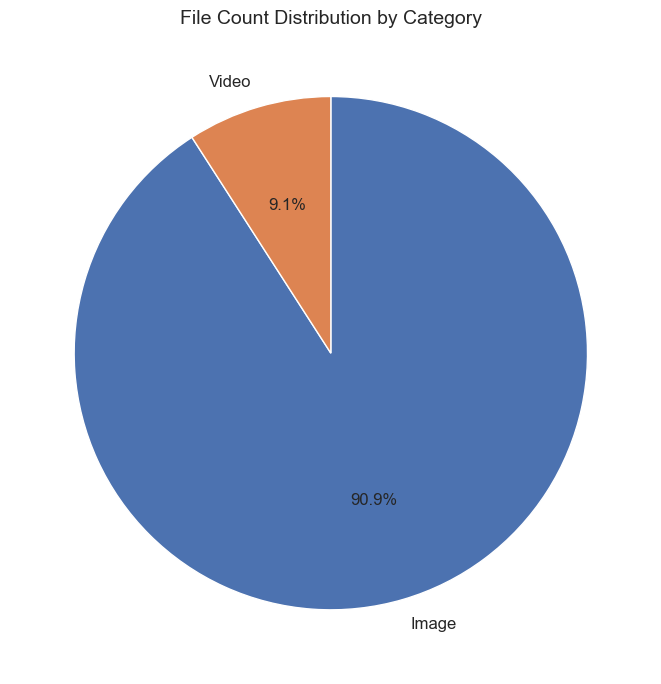

In [45]:
plot_category_count_pie(df_clean)

The visualization shows a highly imbalanced distribution of media files across categories. **Image files account for the vast majority of records**, representing approximately **90.9%** of the total file count, while **Video files contribute around 9.1%**.

This distribution indicates that file creation activity is predominantly image-based, with video files occurring far less frequently in terms of volume. However, this result reflects file count only and does not capture the relative storage impact of each category.

#### 4.2.2. Category Distribution by Storage Size

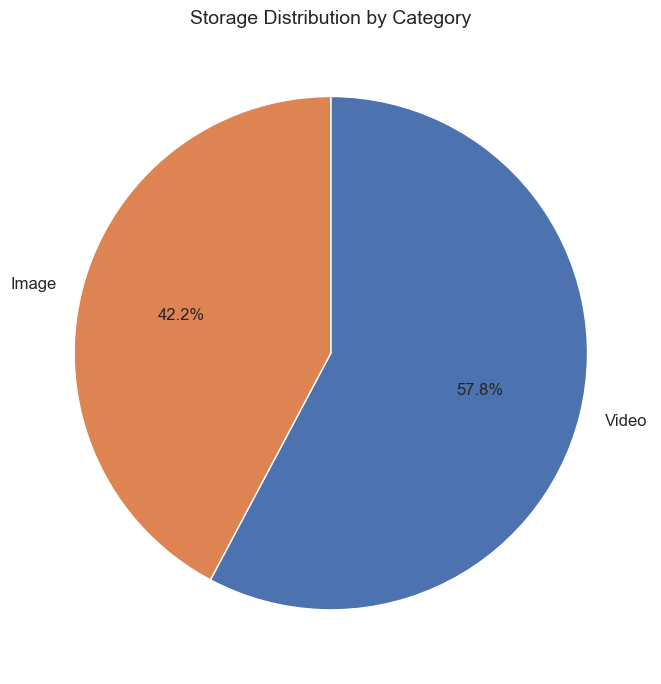

In [46]:
plot_category_size_pie(df_clean)

The visualization shows a markedly different pattern when storage consumption is examined instead of file count. **Video files account for the majority of total storage usage**, contributing approximately **57.8%** of overall storage, while **image files account for around 42.2%**.

Although image files dominate in terms of file count, video files consume a disproportionately larger share of storage. This contrast highlights the importance of analyzing storage usage by size in addition to volume, as file frequency alone does not accurately represent storage impact.

#### 4.2.3. Album Root Distribution by File Count

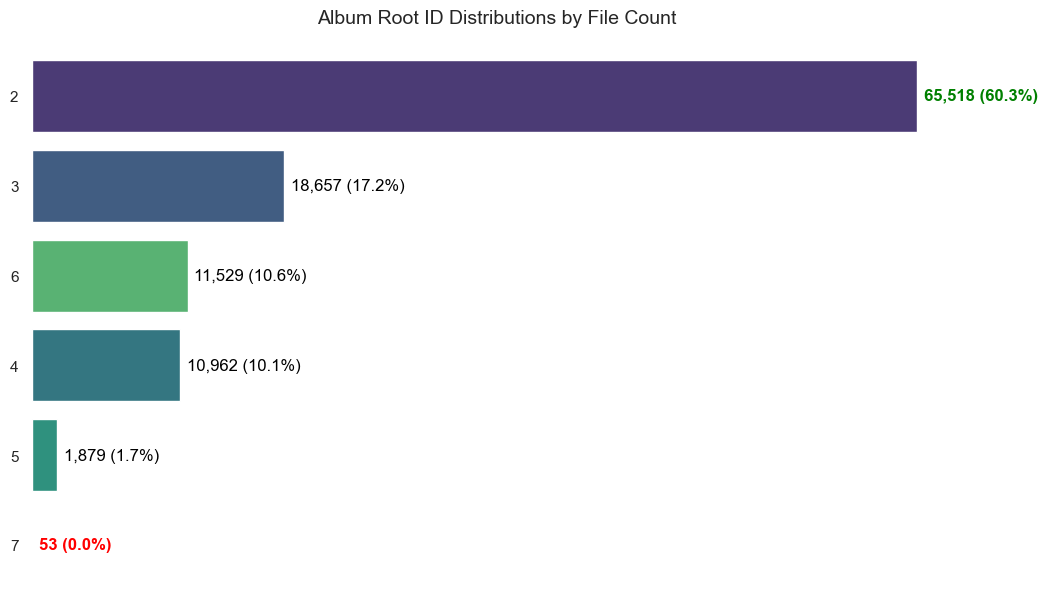

In [47]:
top_n = get_top_n(df_clean, "albumRootId")

plot_count(
    df=df_clean,
    column="albumRootId",
    top_n=top_n,
    title=f"Album Root ID Distributions by File Count",
)


The distribution of files across album root identifiers is highly concentrated. A single album root (**ID 2**) accounts for approximately **60.3%** of all files, indicating a dominant grouping in terms of file volume.

The remaining album roots contribute substantially smaller shares. Album roots **3**, **6**, and **4** collectively account for a meaningful portion of the dataset but are individually far less dominant than the primary album root. Other album roots contribute only marginally to the total file count.

This distribution indicates that file volume is unevenly distributed across album roots, with a strong concentration in a limited subset of groups.


#### 4.2.4. Album Root Distribution by Storage Size

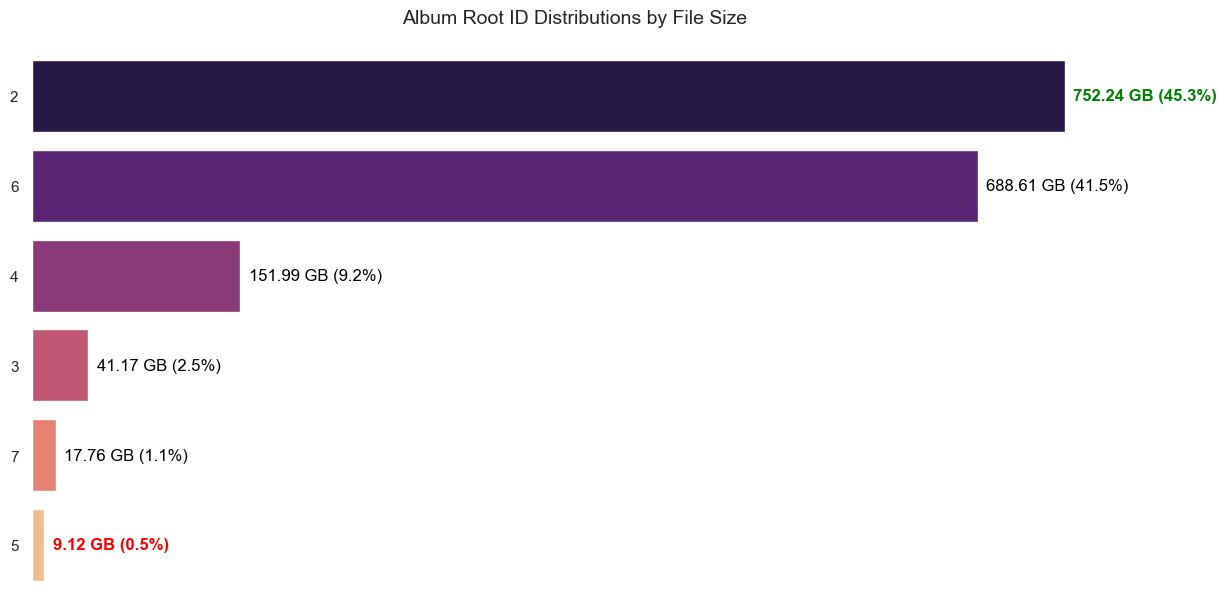

In [48]:
top_n = get_top_n(df_clean, "albumRootId")

plot_sum(
    df=df_clean,
    column="albumRootId",
    top_n=top_n,
    title=f"Album Root ID Distributions by File Size",
)


When storage consumption is examined by album root, a different distribution pattern emerges compared to file count. Album root **ID 2** remains the largest contributor, accounting for approximately **45.3%** of total storage usage.

However, album root **ID 6** contributes nearly as much storage, representing around **41.5%**, despite having a substantially lower file count than album root ID 2. The remaining album roots contribute relatively small proportions of total storage, each accounting for less than 10%.

This comparison indicates that storage usage is not solely driven by file volume. Certain album roots contain fewer files but significantly larger media sizes, highlighting the importance of evaluating both file count and storage size when assessing storage distribution.

#### 4.2.5. File Format Distribution by File Count

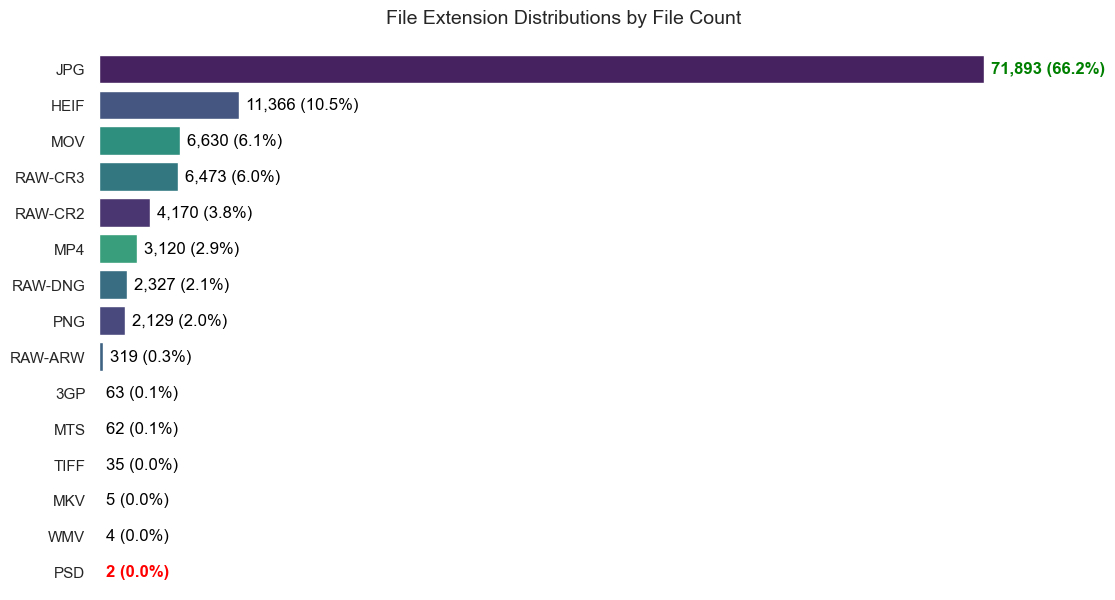

In [49]:
top_n = 100

plot_count(
    df=df_clean,
    column="format",
    top_n=top_n,
    title=f"File Extension Distributions by File Count",
)


The distribution of file formats by count is highly concentrated. The **JPG** format dominates the dataset, accounting for approximately **66.2%** of all files, indicating that the majority of stored media consists of compressed image files.

Several other formats contribute moderate shares, including **HEIF**, **MOV**, and camera-specific **RAW** formats (such as CR2, CR3, and DNG). Together, these formats represent a meaningful portion of the dataset but remain significantly less prevalent than JPG.

A long tail of file formats is also present, with many formats contributing only a negligible number of files. This indicates format diversity within the archive, although file volume is driven primarily by a small subset of dominant formats.


#### 4.2.6. File Format Distribution by Storage Size

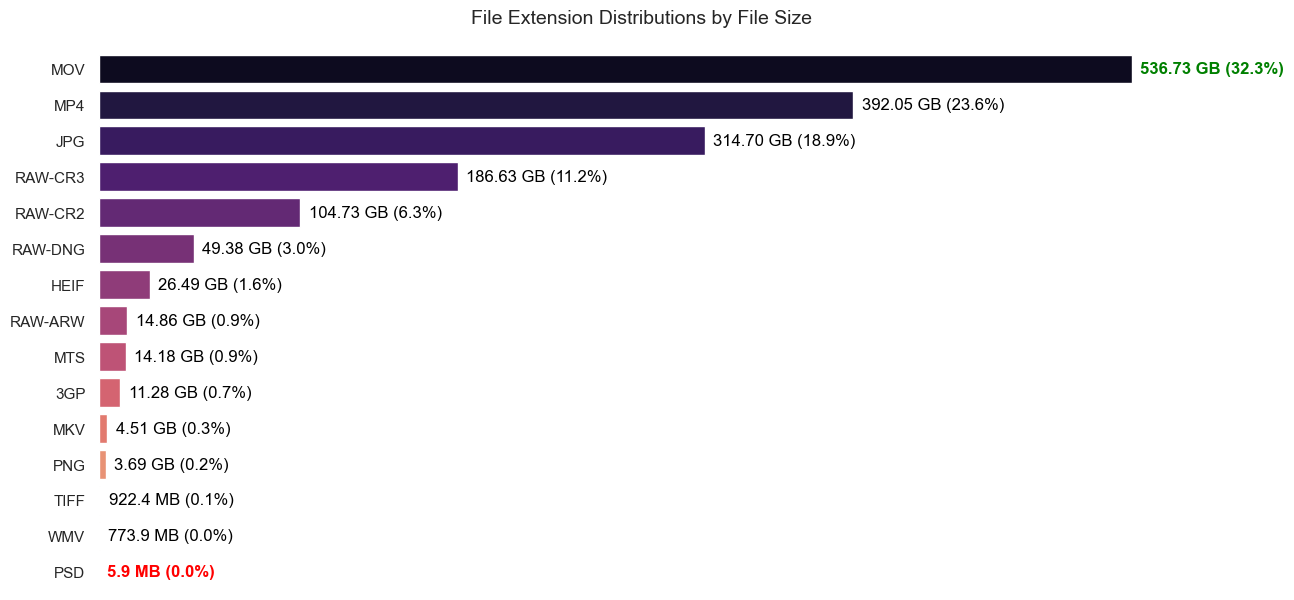

In [50]:
top_n = 100

plot_sum(
    df=df_clean,
    column="format",
    top_n=top_n,
    title=f"File Extension Distributions by File Size",
)


When file formats are evaluated by total storage consumption, the distribution differs substantially from the file count perspective. **Video formats dominate storage usage**, with **MOV** accounting for approximately **32.3%** of total storage and **MP4** contributing around **23.6%**.

Although **JPG** files are the most common by count, they represent a smaller share of total storage at approximately **18.9%**. Camera-specific **RAW** formats collectively contribute a notable portion of storage despite lower file counts, reflecting their larger per-file size.

These results demonstrate that storage consumption is driven primarily by high-resolution video and RAW media formats rather than by the most frequently occurring file types.


#### 4.2.7. Yearly File Count Trend

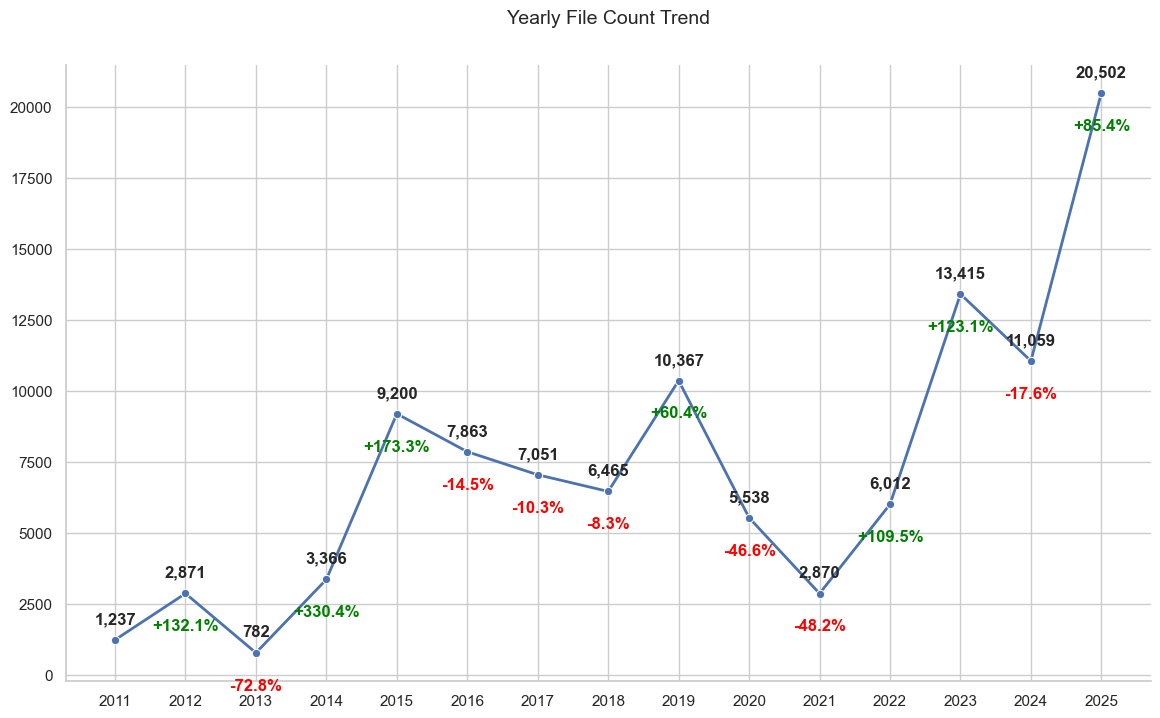

In [51]:
plot_trend_count(
    df=df_clean,
    column="year",
    title="Yearly File Count Trend",
)


The yearly file count trend shows substantial variability in file creation activity over time, with periods of rapid growth and notable declines. Early years exhibit relatively low file volumes, followed by a sharp increase beginning in the mid-2010s.

Several years demonstrate strong year-over-year growth, indicating bursts of file creation activity, while other periods show significant contractions where file counts decline sharply compared to the previous year. This fluctuation suggests that file creation behavior is not steady but occurs in distinct phases rather than following a linear growth pattern.

In more recent years, file counts reach their highest levels in the dataset, reflecting an overall upward trajectory despite intermittent declines. The presence of both positive and negative growth rates highlights the importance of examining temporal trends rather than relying solely on cumulative totals.


#### 4.2.8. Yearly Total File Size Trend

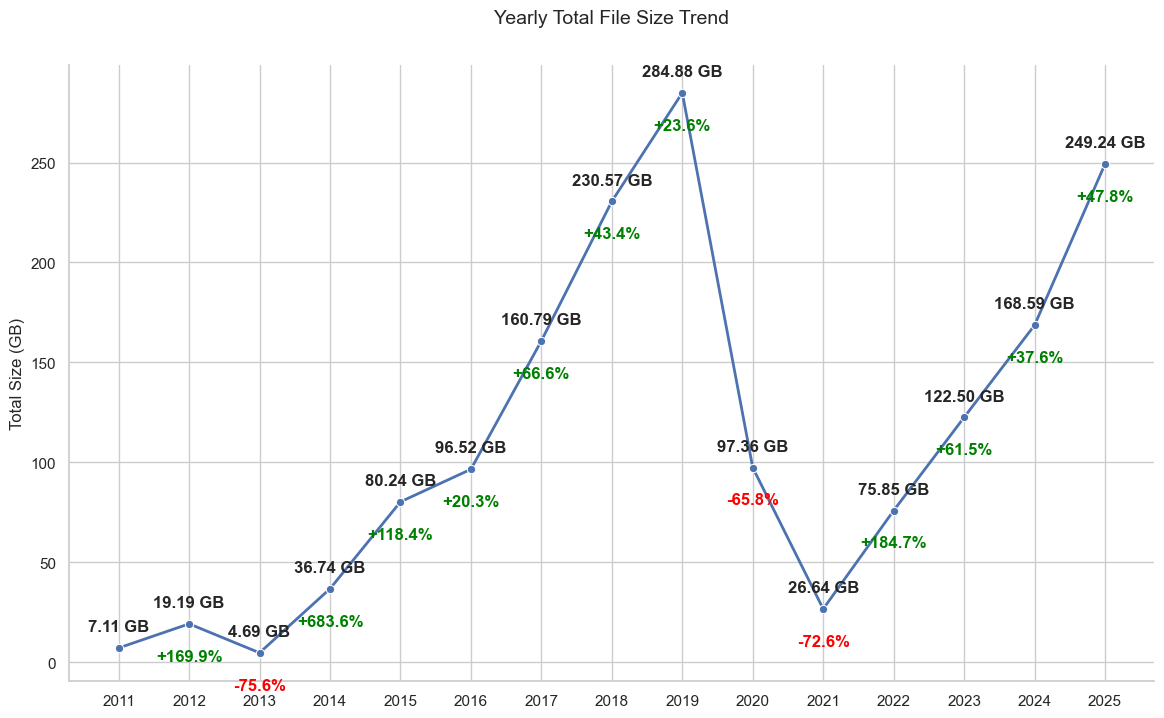

In [52]:
plot_trend_sum(
    df=df_clean,
    column="year",
    title="Yearly Total File Size Trend",
)

The yearly total file size trend reveals pronounced variability in storage growth over time, with periods of rapid expansion and sharp contractions. Early years show relatively low storage accumulation, followed by sustained growth through the mid-to-late 2010s, culminating in a peak around 2019.

A substantial decline in total storage added occurs in the subsequent years, indicating a sharp reduction in yearly storage contribution compared to the prior peak. This contraction is followed by a renewed upward trend in recent years, with storage growth accelerating again and approaching earlier peak levels.

Compared to the file count trend, storage growth exhibits larger fluctuations, suggesting that changes in total storage are driven not only by the number of files but also by variations in average file size. This reinforces the importance of evaluating storage usage through both volume- and size-based temporal analysis.


#### 4.2.9. Monthly File Count Distribution

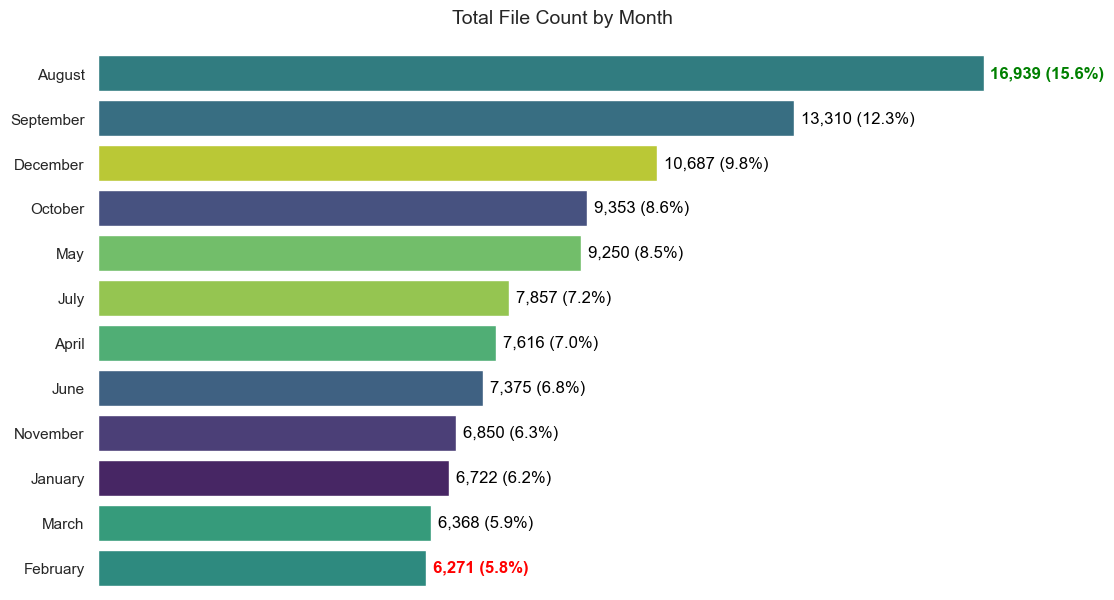

In [53]:
top_n = 12

plot_count(
    df=df_clean,
    column="month_name",
    top_n=top_n,
    title=f"Total File Count by Month",
)


The monthly distribution of file counts shows clear seasonal variation in file creation activity. **August** records the highest number of files, contributing approximately **15.6%** of the total, followed by **September** (**12.3%**) and **December** (**9.8%**).

Mid-year months such as **May**, **July**, and **October** also show elevated activity, while **February** records the lowest file count at approximately **5.8%**. The remaining months exhibit relatively balanced contributions, each accounting for a similar share of total files.

This pattern indicates that file creation is not evenly distributed throughout the year and tends to peak during specific periods, suggesting recurring seasonal behavior in media capture or ingestion.


#### 4.2.10. Monthly Storage Size Distribution

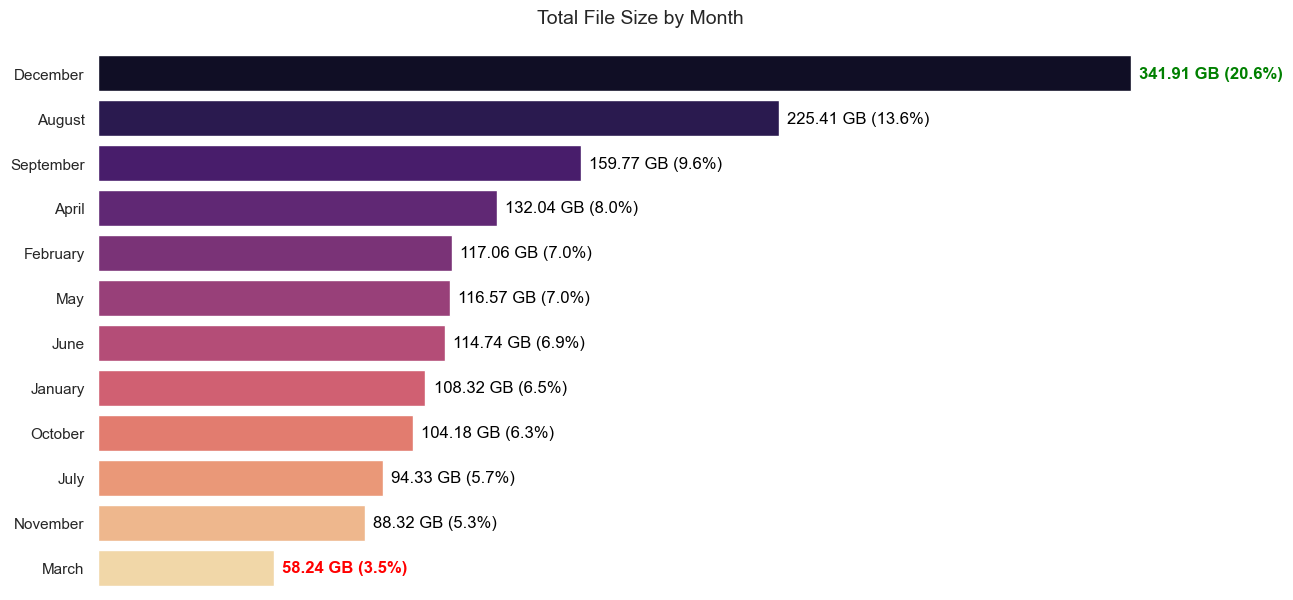

In [54]:
top_n = 12

plot_sum(
    df=df_clean,
    column="month_name",
    top_n=top_n,
    title=f"Total File Size by Month",
)

The monthly distribution of total storage size shows a different pattern compared to file count. **December** accounts for the largest share of storage consumption, contributing approximately **20.6%** of the total, despite not being the highest month by file count.

**August** and **September** also contribute substantial portions of total storage, representing **13.6%** and **9.6%**, respectively. Several months with moderate file counts, such as **April**, **February**, and **May**, exhibit relatively high storage contributions, indicating the presence of larger average file sizes during these periods.

In contrast, **March** contributes the smallest share of total storage at approximately **3.5%**. Overall, this distribution highlights that monthly storage usage is influenced not only by the number of files created but also by variations in file size, reinforcing the importance of evaluating both dimensions in seasonal analysis.


## 5. Share

This phase focuses on synthesizing and communicating the results of the exploratory data analysis in a clear, concise, and decision-relevant manner. The objective is to translate analytical findings into structured insights without introducing new analysis or technical detail.

The focus of this phase is to:
- Summarize key findings derived from exploratory analysis.  
- Highlight dominant patterns and contrasts observed across dimensions.  
- Present insights in a form accessible to both technical and non-technical stakeholders.  

### 5.1. Key Insights
- Media storage usage is unevenly distributed, with a small number of categories, formats, and album roots contributing the majority of total storage consumption.
- File count and storage size exhibit distinct distribution patterns; image files dominate by count, while video and RAW formats account for a larger share of total storage.
- Storage growth over time is variable, with periods of rapid expansion and sharp contraction rather than steady linear growth.
- Seasonal patterns are evident in both file creation and storage usage, with certain months consistently contributing higher volumes and larger storage sizes.
- The dataset is structurally complete and supports reliable exploratory analysis without the need for imputation or corrective preprocessing.

### 5.2. Limitations
- The dataset is derived from a single personal media storage system and may not be representative of broader user behavior or other storage environments.
- Analysis is based solely on file-level metadata; media content, resolution details, and contextual information are not examined.
- Exploratory data analysis identifies patterns and associations but does not establish causal relationships.
- Storage usage patterns may be influenced by application-specific behaviors or configuration choices within the Digikam database from which the data was extracted.


## 6. Act

This phase focuses on translating analytical insights into practical considerations and potential actions that can inform storage management and guide future analytical work.

The focus of this phase is to:
- Identify actionable considerations informed by observed patterns.  
- Support storage planning and organizational decisions using analytical evidence.  
- Outline logical next steps for extending or deepening the analysis.  

### 6.1. Recommendations
- Prioritize storage planning and optimization efforts on high-impact formats, particularly video and RAW media, which contribute disproportionately to total storage usage.
- Use storage size–based metrics alongside file count when evaluating storage growth, archival policies, or retention strategies.
- Review album roots with high storage concentration to improve organizational clarity and long-term manageability.
- Incorporate observed temporal and seasonal patterns into storage capacity planning to anticipate periods of increased growth.

### 6.2. Next Steps
- Conduct deeper segmentation analysis across albums, formats, or time periods to identify high-growth or high-impact subsets.
- Extend temporal analysis to finer granularities, such as day-of-week or event-based patterns, to refine understanding of usage behavior.
- Consider predictive or scenario-based modeling for long-term storage planning if analytical objectives expand beyond exploratory analysis.